Using TensorFlow backend.


Epoch 1/20
16314/16314 [==============================] - 68s - loss: 0.0437 - val_loss: 0.0298

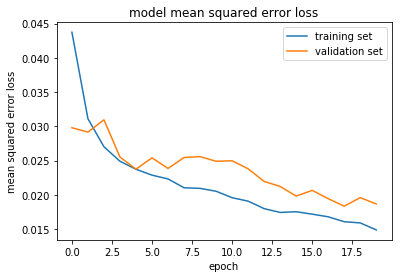

In [1]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense,Lambda, Cropping2D,Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

samples = []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
#samples = samples[:-1000]
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import sklearn


def generator(samples, batch_size=32):
    correction = 0.23
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                center_image = cv2.cvtColor(cv2.imread(batch_sample[0]), cv2.COLOR_RGB2GRAY)
                left_image = cv2.cvtColor(cv2.imread(batch_sample[1]), cv2.COLOR_RGB2GRAY)
                right_image = cv2.cvtColor(cv2.imread(batch_sample[2]), cv2.COLOR_RGB2GRAY)
                
                center_image = center_image[:, :, np.newaxis]
                left_image = left_image[:, :, np.newaxis]
                right_image = right_image[:, :, np.newaxis]
                
                center_angle = float(batch_sample[3])
                left_angle = float(center_angle+correction)
                right_angle = float(center_angle-correction)
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=50)
validation_generator = generator(validation_samples, batch_size=50)


model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x:((x/255.0)-0.5),input_shape = (160,320,1)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))


model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 3*len(train_samples), validation_data=validation_generator, nb_val_samples=3*len(validation_samples), nb_epoch=20, verbose=1)

model.save('model.h5')

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

20394
[ 172   38  216  100  160  306  499  686 4894  939 5039  809 4723  437  307
  133   76   61  218]


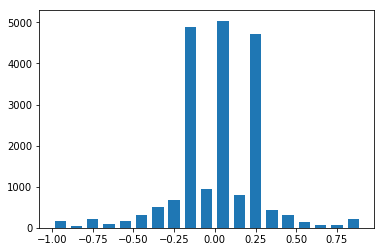

In [1]:
import csv
import cv2
import numpy as np

correction = 0.2
car_images=[]
steering_angles=[]
with open('driving_log.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        steering_center = float(row[3])

        
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        steering_angles.append(steering_center) 
        steering_angles.append(steering_left) 
        steering_angles.append(steering_right) 

        
        
        


y_train = np.asarray(steering_angles)


print(len(y_train))

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
fig = plt.figure()
hist, bins = np.histogram(y_train, bins=np.arange(-1,1,0.1))
print(hist)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
fig.savefig('dataset_visual.jpg')